In [1]:
import pandas as pd
import numpy as np
import edit_distance

In [2]:
df0=pd.read_csv("exp123_page1.csv", encoding='utf8')
df1=pd.read_csv("exp123_page2.csv", encoding='utf8')
zdf=pd.read_excel("zhuyin2ipa.xlsx",engine='openpyxl')

#zdf
#df1

In [3]:
title = ['F1','F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'M1', 'M2', 'M3', 
         'M5', 'M6', 'M7','M8', 'M9']
#phoneme=[]
vowel=['i', 'y', 'e', 'ɛ',  'a', 'ɨ', 'ə', 'u', 'o', 'ɔ', 'ɤ']
consonent=['p', 'pʰ', 'm', 'f', 't', 'tʰ', 'n', 'l', 's', 'ʂ', 'ʐ', 'ts', 'tsʰ', 'tʂ', 'tʂʰ', 'ɕ', 'tɕ', 'tɕʰ', 'k', 'kʰ',    
           'ŋ',  'x', 'j', 'ɥ', 'w']
nvowel=['∅']+vowel
nconsonent=['∅']+consonent

adlabel= ["ISCD", "ISG1D", "F2G2D", "ISCG1D", "SVD", "ISN1D", "FSN2D", "ISCA", "ISG1A", "FSG2A", "ISCG1A", "SVA", 
          "ISN1A", "FSN2A"]
fsound=['51','55','35','21', 'y']
phoneme = vowel + consonent
sorted_phoneme = sorted(phoneme, key=len, reverse=True)
sorted_phoneme.append('∅')

print(consonent, vowel)
print(sorted_phoneme)

['p', 'pʰ', 'm', 'f', 't', 'tʰ', 'n', 'l', 's', 'ʂ', 'ʐ', 'ts', 'tsʰ', 'tʂ', 'tʂʰ', 'ɕ', 'tɕ', 'tɕʰ', 'k', 'kʰ', 'ŋ', 'x', 'j', 'ɥ', 'w'] ['i', 'y', 'e', 'ɛ', 'a', 'ɨ', 'ə', 'u', 'o', 'ɔ', 'ɤ']
['tsʰ', 'tʂʰ', 'tɕʰ', 'pʰ', 'tʰ', 'ts', 'tʂ', 'tɕ', 'kʰ', 'i', 'y', 'e', 'ɛ', 'a', 'ɨ', 'ə', 'u', 'o', 'ɔ', 'ɤ', 'p', 'm', 'f', 't', 'n', 'l', 's', 'ʂ', 'ʐ', 'ɕ', 'k', 'ŋ', 'x', 'j', 'ɥ', 'w', '∅']


In [29]:
def phoneme_segmentation(item):
    #print(item)
    if item == '':
        return []
    
    for i in sorted_phoneme:
        if item.find(i) == 0:
            #print("Match", i)
            sl=[i]
            srl=phoneme_segmentation(item[len(i):])
            if srl is None:
                print("No match", item)
                return sl
            else:
                return(sl+srl)

In [30]:
def conf_matrix_inc(conconf, vowconf, lits, lixs):
    for ilits, ilixs in zip(lits, lixs):
        isConsonent = False
        isVowel = False

        if ilits == '∅' or ilixs == '∅':
            if ilits in consonent or ilixs in consonent:
                isConsonent = True
            elif ilits in vowel or ilixs in vowel:
                isVowel = True
            else:
                print("Illegal phoneme:", ilits, ilixs)
                continue
        else: 
            if ilits in consonent and ilixs in consonent:
                isConsonent = True
            elif ilits in vowel and ilixs in vowel:
                isVowel = True
            else:
                print("Illegal phoneme:", ilits, ilixs)
                continue
        if isConsonent:
            conconf.loc[ilits][ilixs] = conconf.loc[ilits][ilixs] +1
        else:
            vowconf.loc[ilits][ilixs] = vowconf.loc[ilits][ilixs] +1                
                

In [52]:
def to_cgvn(zdf,plist):
    cgvn=[]
    for aa in plist:
        cgvntxt = zdf[zdf['IPA']==aa].CGVN.to_string(index=False).replace(' ','')
        cgvn.append(cgvntxt)

    return(cgvn)

In [53]:
def to_oplist(oplist):
    pop=[]
    for op in oplist:
        pop.append(op[0])
        
    return pop

In [54]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def plot_conf(conconf, vowconf):
    plt.figure(figsize = (15,12))
    #plt.figure()
    sn.heatmap(conconf, annot=True, fmt="d", cmap="YlGnBu")
    plt.xlabel('Target', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('Response', fontsize = 15)
    
    plt.figure(figsize=(15,12))
    #plt.figure()
    sn.heatmap(vowconf, annot=True, fmt="d", cmap="YlGnBu")
    plt.xlabel('Target', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('Response', fontsize = 15)

In [70]:
#(C)(G)V(X)中的phonemes都要一樣，C不見，就是ISCD
#                               G不見，就是ISGD
#                               V不見，就是SVD
#                               X不見，就是FSCD
#(C)(G)V(X)中的phonemes都要一樣，增加C，就是ISCA
#                               增加G，就是ISGA
#                               增加V，就是SVA
#                               增加X，就是FSCA
# (C)(G)V(X)中的phonemes,如果2個不一樣的是C＋V，C＋X就是multiple. 
#                           如果2個不一樣的是C＋G，V＋X就是LU
# (C)(G)V(X)中全部不一樣但聲調一樣是Syllable. 
# (C)(G)V(X)+tone不一樣是word

def misclassifer(oper, lits, lixs, cgvn, cgvn2, adrcount):
    #print(oper, lits, lixs, cgvn, cgvn2, adrcount)
    
    cglen=len(cgvn)
    cg2len=len(cgvn2)
    adindex = None
    
    if 'delete' in oper:
        #print(len(cgvn))
        idx = oper.index('delete')
        #print("delete index", idx)
        dcg = cgvn[idx]
        #print(dcg)
        if dcg == 'C':
            adindex = "ISCD"
        elif dcg == 'G':
            if idx == 0:
                adindex = "ISG1D"
            elif idx == cglen - 1:
                adindex = "F2G2D"
            else:
                adindex = "ISCG1D"
        elif dcg == 'V':
            adindex = "SVD"
        elif dcg == 'N':
            if idx == 0:
                adindex = "ISN1D"
            else:
                adindex = "FSN2D"
                #print("should be")
        else:
            print("Error")
            return
        #print(adindex)
    elif 'insert' in oper:
        #print(len(cgvn))
        idx = oper.index('insert')
        #print(dop, idx)
        dcg = cgvn2[idx]
        if dcg == 'C':
            adindex = "ISCA"
        elif dcg == 'G':
            if idx == 0:
                adindex = "ISG1A"
            elif idx == cg2len - 1:
                adindex = "FSG2A"
            else:
                adindex = "ISCG1A"
        elif dcg == 'V':
            adindex = "SVA"
        elif dcg == 'N':
            if idx == 0:
                adindex = "ISN1A"
            else:
                adindex = "FSN2A"
        else:
            print("Error")
            return
    elif 'replace' in oper:
        return
    else:
        print("Error in opcode")
        return
    
    #print("adindex=", adindex)
    if adindex != None:
        #print(adindex)
        adrcount[adindex] = adrcount[adindex]+1
 
    return

#misclassifer(['equal', 'equal', 'delete'], ['p', 'a', 'n'], ['p', 'a'], ['C', 'V', 'N'], ['C', 'V'], adrcount)

In [ ]:
# 底下為(C)(G)V(X)超過一個phoneme的組合，其中涵蓋2個phonemes 被replaced或者其中一個deleted/added + 一個replacement

# C+V	Multiple
# (could be two replacements or one del/add+ one replacement)	 E.g., 
# CG1VG2  CG1VG2 (C≠C, V≠V); C＋V都被其他的C＋V replaced

# CG1VG2  G1VG2 (V≠V); C不見，V被其他V replaced	 Multiple
# C+X (X=G or N)	Multiple
# (could be two replacements or one del/add+ one replacement)	CG1VG2  CG1VG2 (C≠C, G2≠G2)	 Multiple
# G1+N2
# N1+N2	Multiple
# (could be two replacements or one del/add+ one replacement)
# C+G1
# N1+G1	Larger Units (LU) (must be replacement)
# V+G2 V+N2	Larger Units (LU) (must be replacement)
# (C)(G)V(X) 全部都不Match,聲調有match -> Syllable
# (C)(G)V(X) 全部都不Match，聲調也不match -> Word

def misclassifer2(oper, lits, lixs, cgvn, cgvn2, adrcount):
    return

Target ['ta 51-tʰu 35-tʰa 51-tu 51-tan 51-tʰaw 51-tʰan 51-taw 51', 'tʂʰa 51-nu 51-na 51-tʂʰu 51-tjɛn 55-naw 51-nan 35-tʂʰaw 35', 'pa 51-mu 51-ma 51-pu 51-pan 51-maw 51-man 51-paw 51', 'ta 51-mu 51-ma 51-tu 51-tan 51-maw 51-man 51-taw 51', 'tʂan 51-nu 51-na 51-tʂu 51-tʂan 51-naw 51-nan 35-tʂaw 51', 'tʰa 55-tsu 55-tsa 55-tʰu 55-tʰan 55-tsaw 55-tsan 55-tʰaw 55', 'pa 51-tu 51-ta 51-pu 51-pan 51-taw 51-tan 51-paw 51', 'tʰa 51-tʂu 51-tʂa 51-tʰu 21-tʰan 51-tʂaw 51-tʂan 51-tʰaw 51', 'sa 51-nu 51-na 51-su 51-san 51-naw 51-nan 51-saw 55', 'tʂa 51-lu 51-la 51-tʂu 51-tʂan 51-law 51-lan 51-tʂaw 51', 'pa 55-tʰu 55-tʰa 55-pu 55-pan 55-tʰaw 55-tʰan 55-paw 55', 'tʰa 55-ʂu 55-ʂa 55-tʰu 55-tʰan 55-ʂaw 55-ʂan 55-tʰaw 55', 'sa 51-mu 51-ma 51-su 51-san 51-maw 51-man 51-saw 51', 'pa 51-pʰu 51-pʰa 51-pu 51-pan 51-pʰaw 51-pʰan 51-paw 51', 'tsa 35-nu 35-na 35-tsu 35-tsan 35-naw 35-nan 35-tsaw 35', 'ma 51-nu 51-na 51-mu 51-man 51-naw 51-nan 35-maw 51', 'ma 51-lu 51-la 51-mu 51-man 51-law 51-lan 51-maw 51', 'tʂa 

['tʰ', 'a', 'n'] ['p', 'a'] ['C', 'V', 'N'] ['C', 'V'] 55 51 2 ['replace', 'equal', 'delete']
['p', 'a', 'w'] ['tʰ', 'u'] ['C', 'V', 'G'] ['C', 'V'] 55 55 3 ['delete', 'replace', 'replace']
['tʰ', 'a'] ['s', 'a', 'n'] ['C', 'V'] ['C', 'V', 'N'] 55 55 2 ['replace', 'equal', 'insert']
['ʂ', 'a'] ['n', 'a', 'n'] ['C', 'V'] ['N', 'V', 'N'] 55 55 2 ['replace', 'equal', 'insert']
['ʂ', 'a', 'n'] ['tʰ', 'u'] ['C', 'V', 'N'] ['C', 'V'] 55 55 3 ['delete', 'replace', 'replace']
['m', 'a', 'w'] ['m', 'u'] ['N', 'V', 'G'] ['N', 'V'] 51 51 2 ['equal', 'delete', 'replace']
['tʂʰ', 'a'] ['tsʰ', 'a', 'n'] ['C', 'V'] ['C', 'V', 'N'] 55 55 2 ['replace', 'equal', 'insert']
['n', 'u'] ['m', 'a', 'w'] ['N', 'V'] ['N', 'V', 'G'] 51 51 3 ['insert', 'replace', 'replace']
['l', 'a', 'w'] ['l', 'w', 'ɔ'] ['C', 'V', 'G'] ['C', 'G', 'V'] 51 51 2 ['equal', 'replace', 'replace']
['s', 'a'] ['f', 'o', 'ŋ'] ['C', 'V'] ['C', 'V', 'N'] 51 55 3 ['insert', 'replace', 'replace']
['tsʰ', 'a', 'n'] ['s', 'a'] ['C', 'V', 'N'

['t', 'a', 'w'] ['p', 'u'] ['C', 'V', 'G'] ['C', 'V'] 51 51 3 ['delete', 'replace', 'replace']
['tʂ', 'a'] ['t', 'a', 'n'] ['C', 'V'] ['C', 'V', 'N'] 51 51 2 ['replace', 'equal', 'insert']
['tʂ', 'a', 'n'] ['tʰ', 'a'] ['C', 'V', 'N'] ['C', 'V'] 51 55 2 ['replace', 'equal', 'delete']
['n', 'a'] ['s', 'a', 'n'] ['N', 'V'] ['C', 'V', 'N'] 51 51 2 ['replace', 'equal', 'insert']
['s', 'a', 'n'] ['tʰ', 'a'] ['C', 'V', 'N'] ['C', 'V'] 51 51 2 ['replace', 'equal', 'delete']
['n', 'a', 'w'] ['t', 'u'] ['N', 'V', 'G'] ['C', 'V'] 51 51 3 ['delete', 'replace', 'replace']
['l', 'a'] ['n', 'a', 'n'] ['C', 'V'] ['N', 'V', 'N'] 51 51 2 ['replace', 'equal', 'insert']
['tʂ', 'a', 'n'] ['l', 'a'] ['C', 'V', 'N'] ['C', 'V'] 51 51 2 ['replace', 'equal', 'delete']
['tʰ', 'a', 'w'] ['pʰ', 'u'] ['C', 'V', 'G'] ['C', 'V'] 55 55 3 ['delete', 'replace', 'replace']
['ʂ', 'a', 'w'] ['ʂ', 'u'] ['C', 'V', 'G'] ['C', 'V'] 55 55 2 ['equal', 'delete', 'replace']
['m', 'a', 'w'] ['f', 'u'] ['N', 'V', 'G'] ['C', 'V'] 51 

['tʂ', 'a', 'w'] ['tʂ', 'u'] ['C', 'V', 'G'] ['C', 'V'] 51 51 2 ['equal', 'delete', 'replace']
['tʰ', 'a'] ['ʂ', 'a', 'n'] ['C', 'V'] ['C', 'V', 'N'] 55 55 2 ['replace', 'equal', 'insert']
['tʰ', 'a', 'w'] ['tʰ', 'u'] ['C', 'V', 'G'] ['C', 'V'] 55 55 2 ['equal', 'delete', 'replace']
['m', 'a', 'w'] ['s', 'u'] ['N', 'V', 'G'] ['C', 'V'] 51 51 3 ['delete', 'replace', 'replace']
['s', 'a', 'w'] ['ts', 'u'] ['C', 'V', 'G'] ['C', 'V'] 51 35 3 ['delete', 'replace', 'replace']
['p', 'a'] ['s', 'a', 'n'] ['C', 'V'] ['C', 'V', 'N'] 51 51 2 ['replace', 'equal', 'insert']
['p', 'a', 'n'] ['pʰ', 'u'] ['C', 'V', 'N'] ['C', 'V'] 51 51 3 ['delete', 'replace', 'replace']
['pʰ', 'a', 'w'] ['p', 'u'] ['C', 'V', 'G'] ['C', 'V'] 51 51 3 ['delete', 'replace', 'replace']
['pʰ', 'a', 'n'] ['pʰ', 'u'] ['C', 'V', 'N'] ['C', 'V'] 51 51 2 ['equal', 'delete', 'replace']
['m', 'a'] ['ts', 'a', 'n'] ['N', 'V'] ['C', 'V', 'N'] 51 51 2 ['replace', 'equal', 'insert']
['n', 'a', 'n'] ['m', 'a'] ['N', 'V', 'N'] ['N', 'V

['tʂʰ', 'u'] ['n', 'a'] ['C', 'V'] ['N', 'V'] 51 51 2 ['replace', 'replace']
['n', 'a', 'w'] ['n', 'u'] ['N', 'V', 'G'] ['N', 'V'] 51 51 2 ['equal', 'delete', 'replace']
['p', 'a', 'n'] ['t', 'a'] ['C', 'V', 'N'] ['C', 'V'] 51 51 2 ['replace', 'equal', 'delete']
['m', 'a', 'w'] ['m', 'u'] ['N', 'V', 'G'] ['N', 'V'] 51 51 2 ['equal', 'delete', 'replace']
['tʂ', 'a', 'n'] ['tʰ', 'a'] ['C', 'V', 'N'] ['C', 'V'] 51 51 2 ['replace', 'equal', 'delete']
['tʂ', 'u'] ['t', 'a', 'w'] ['C', 'V'] ['C', 'V', 'G'] 51 51 3 ['insert', 'replace', 'replace']
['n', 'a', 'w'] ['l', 'u'] ['N', 'V', 'G'] ['C', 'V'] 51 51 3 ['delete', 'replace', 'replace']
['ts', 'a'] ['tʰ', 'a', 'n'] ['C', 'V'] ['C', 'V', 'N'] 55 55 2 ['replace', 'equal', 'insert']
['tʰ', 'u'] ['ts', 'a', 'w'] ['C', 'V'] ['C', 'V', 'G'] 55 55 3 ['insert', 'replace', 'replace']
['p', 'u'] ['t', 'a', 'w'] ['C', 'V'] ['C', 'V', 'G'] 51 51 3 ['insert', 'replace', 'replace']
['tʰ', 'u'] ['t', 'a', 'w'] ['C', 'V'] ['C', 'V', 'G'] 21 51 3 ['insert

['tʰ', 'a', 'n'] ['p', 'a'] ['C', 'V', 'N'] ['C', 'V'] 55 55 2 ['replace', 'equal', 'delete']
['p', 'a', 'w'] ['tʰ', 'u'] ['C', 'V', 'G'] ['C', 'V'] 55 55 3 ['delete', 'replace', 'replace']
['ʂ', 'a', 'n'] ['tʰ', 'a'] ['C', 'V', 'N'] ['C', 'V'] 55 55 2 ['replace', 'equal', 'delete']
['n', 'a', 'w'] ['m', 'u'] ['N', 'V', 'G'] ['N', 'V'] 35 51 3 ['delete', 'replace', 'replace']
['l', 'a'] ['n', 'a', 'n'] ['C', 'V'] ['N', 'V', 'N'] 51 51 2 ['replace', 'equal', 'insert']
['l', 'a', 'w'] ['l', 'u'] ['C', 'V', 'G'] ['C', 'V'] 51 51 2 ['equal', 'delete', 'replace']
['n', 'a', 'w'] ['t', 'u'] ['N', 'V', 'G'] ['C', 'V'] 51 51 3 ['delete', 'replace', 'replace']
['ʂ', 'a'] ['tʂʰ', 'a', 'n'] ['C', 'V'] ['C', 'V', 'N'] 51 51 2 ['replace', 'equal', 'insert']
['t', 'a', 'n'] ['tʰ', 'a'] ['C', 'V', 'N'] ['C', 'V'] 55 55 2 ['replace', 'equal', 'delete']
['s', 'a', 'w'] ['s', 'u'] ['C', 'V', 'G'] ['C', 'V'] 55 51 2 ['equal', 'delete', 'replace']
['l', 'a'] ['n', 'a', 'n'] ['C', 'V'] ['N', 'V', 'N'] 55 3

['l', 'a', 'w'] ['m', 'u'] ['C', 'V', 'G'] ['N', 'V'] 51 51 3 ['delete', 'replace', 'replace']
['m', 'a', 'w'] ['m', 'u'] ['N', 'V', 'G'] ['N', 'V'] 51 51 2 ['equal', 'delete', 'replace']
['m', 'a', 'w'] ['tʂ', 'u'] ['N', 'V', 'G'] ['C', 'V'] 51 51 3 ['delete', 'replace', 'replace']
['tʂ', 'a', 'w'] ['tʂ', 'u'] ['C', 'V', 'G'] ['C', 'V'] 51 51 2 ['equal', 'delete', 'replace']
['l', 'a', 'w'] ['n', 'u'] ['C', 'V', 'G'] ['N', 'V'] 51 51 3 ['delete', 'replace', 'replace']
['n', 'a', 'w'] ['n', 'u'] ['N', 'V', 'G'] ['N', 'V'] 51 51 2 ['equal', 'delete', 'replace']
['p', 'a'] ['m', 'a', 'n'] ['C', 'V'] ['N', 'V', 'N'] 51 51 2 ['replace', 'equal', 'insert']
['ʂ', 'a'] ['m', 'a', 'n'] ['C', 'V'] ['N', 'V', 'N'] 51 51 2 ['replace', 'equal', 'insert']
['p', 'u'] ['s', 'a', 'w'] ['C', 'V'] ['C', 'V', 'G'] 51 51 3 ['insert', 'replace', 'replace']
['t', 'a', 'n'] ['n', 'a'] ['C', 'V', 'N'] ['N', 'V'] 51 51 2 ['replace', 'equal', 'delete']
['t', 'a', 'n'] ['n', 'a'] ['C', 'V', 'N'] ['N', 'V'] 55 51

['tʰ', 'a', 'w'] ['tʰ', 'u'] ['C', 'V', 'G'] ['C', 'V'] 51 51 2 ['equal', 'delete', 'replace']
['n', 'a'] ['t', 'a', 'n'] ['N', 'V'] ['C', 'V', 'N'] 51 51 2 ['replace', 'equal', 'insert']
['t', 'j', 'ɛ', 'n'] ['n', 'a', 'n'] ['C', 'G', 'V', 'N'] ['N', 'V', 'N'] 55 51 3 ['delete', 'replace', 'replace', 'equal']
['m', 'a'] ['p', 'a', 'n'] ['N', 'V'] ['C', 'V', 'N'] 51 51 2 ['replace', 'equal', 'insert']
['p', 'u'] ['t', 'a', 'w'] ['C', 'V'] ['C', 'V', 'G'] 51 51 3 ['insert', 'replace', 'replace']
['t', 'u'] ['t', 'a', 'w'] ['C', 'V'] ['C', 'V', 'G'] 51 51 2 ['equal', 'insert', 'replace']
['m', 'a', 'w'] ['p', 'u'] ['N', 'V', 'G'] ['C', 'V'] 51 51 3 ['delete', 'replace', 'replace']
['ts', 'a'] ['n', 'a', 'n'] ['C', 'V'] ['N', 'V', 'N'] 55 51 2 ['replace', 'equal', 'insert']
['tʰ', 'a', 'w'] ['ts', 'a', 'n'] ['C', 'V', 'G'] ['C', 'V', 'N'] 55 55 2 ['replace', 'equal', 'replace']
['t', 'a', 'w'] ['tʰ', 'u'] ['C', 'V', 'G'] ['C', 'V'] 51 51 3 ['delete', 'replace', 'replace']
['tʂ', 'a', 'n']

['ɤ'] ['l', 'y'] ['V'] ['C', 'V'] 51 51 2 ['insert', 'replace']
['j', 'o', 'w'] ['o', 'ŋ'] ['G', 'V', 'G'] ['V', 'N'] 55 55 2 ['delete', 'equal', 'replace']
['a', 'ŋ'] ['j', 'a'] ['V', 'N'] ['G', 'V'] 55 55 2 ['replace', 'replace']
['o', 'ŋ'] ['i'] ['V', 'N'] ['V'] 55 55 2 ['delete', 'replace']
['w', 'ə', 'n'] ['w', 'o', 'ŋ'] ['G', 'V', 'N'] ['G', 'V', 'N'] 51 51 2 ['equal', 'replace', 'replace']
['o', 'ŋ'] ['p', 'ə', 'n'] ['V', 'N'] ['C', 'V', 'N'] 51 51 3 ['insert', 'replace', 'replace']
['p', 'ə', 'n'] ['w', 'o', 'ŋ'] ['C', 'V', 'N'] ['G', 'V', 'N'] 51 51 3 ['replace', 'replace', 'replace']
['w', 'ə', 'n'] ['w', 'o', 'ŋ'] ['G', 'V', 'N'] ['G', 'V', 'N'] 51 51 2 ['equal', 'replace', 'replace']
['o', 'ŋ'] ['p', 'ə', 'n'] ['V', 'N'] ['C', 'V', 'N'] 51 51 3 ['insert', 'replace', 'replace']
['w', 'e', 'j'] ['a', 'j'] ['G', 'V', 'G'] ['V', 'G'] 55 55 2 ['delete', 'replace', 'equal']
['t', 'a', 'n'] ['tʰ', 'w', 'a', 'n'] ['C', 'V', 'N'] ['C', 'G', 'V', 'N'] 55 55 2 ['insert', 'replace', 'e

['s', 'ɨ'] ['ə', 'n'] ['C', 'V'] ['V', 'N'] 55 55 2 ['replace', 'replace']
['l', 'i'] ['y'] ['C', 'V'] ['V'] 51 51 2 ['delete', 'replace']
['y'] ['l', 'u'] ['V'] ['C', 'V'] 51 51 2 ['insert', 'replace']
['tʰ', 'ɤ'] ['l', 'u'] ['C', 'V'] ['C', 'V'] 51 51 2 ['replace', 'replace']
['ɤ'] ['l', 'u'] ['V'] ['C', 'V'] 51 35 2 ['insert', 'replace']
['l', 'ɤ'] ['ɥ', 'ɛ'] ['C', 'V'] ['G', 'V'] 51 51 2 ['replace', 'replace']
['o', 'ŋ'] ['a', 'n'] ['V', 'N'] ['V', 'N'] 55 55 2 ['replace', 'replace']
['s', 'ɤ'] ['tsʰ', 'ɨ'] ['C', 'V'] ['C', 'V'] 51 51 2 ['replace', 'replace']
['ts', 'ɤ'] ['u'] ['C', 'V'] ['V'] 51 21 2 ['delete', 'replace']
['o', 'ŋ'] ['w', 'ə', 'n'] ['V', 'N'] ['G', 'V', 'N'] 51 51 3 ['insert', 'replace', 'replace']
['o', 'ŋ'] ['w', 'ə', 'n'] ['V', 'N'] ['G', 'V', 'N'] 51 51 3 ['insert', 'replace', 'replace']
['p', 'i', 'n'] ['t', 'i', 'ŋ'] ['C', 'V', 'N'] ['C', 'V', 'N'] 55 55 2 ['replace', 'equal', 'replace']
['t', 'i', 'ŋ'] ['p', 'ə', 'n'] ['C', 'V', 'N'] ['C', 'V', 'N'] 55 51 3

['w', 'a', 'ŋ'] ['a', 'n'] ['G', 'V', 'N'] ['V', 'N'] 55 55 2 ['delete', 'equal', 'replace']
['w', 'ə', 'n'] ['i'] ['G', 'V', 'N'] ['V'] 51 55 3 ['delete', 'delete', 'replace']
['w', 'a'] ['tʰ', 'a', 'n'] ['G', 'V'] ['C', 'V', 'N'] 55 55 2 ['replace', 'equal', 'insert']
['tʰ', 'a', 'n'] ['tʰ', 'u'] ['C', 'V', 'N'] ['C', 'V'] 55 55 2 ['equal', 'delete', 'replace']
['a', 'n'] ['u'] ['V', 'N'] ['V'] 55 55 2 ['delete', 'replace']
['l', 'ɤ'] ['n', 'o', 'ŋ'] ['C', 'V'] ['N', 'V', 'N'] 51 55 3 ['insert', 'replace', 'replace']
['l', 'i', 'ŋ'] ['n', 'ə', 'n'] ['C', 'V', 'N'] ['N', 'V', 'N'] 51 51 3 ['replace', 'replace', 'replace']
['i'] ['n', 'ə', 'n'] ['V'] ['N', 'V', 'N'] 51 51 3 ['insert', 'insert', 'replace']
['pʰ', 'a', 'n'] ['tʰ', 'a'] ['C', 'V', 'N'] ['C', 'V'] 55 55 2 ['replace', 'equal', 'delete']
['pʰ', 'o', 'w'] ['pʰ', 'a', 'n'] ['C', 'V', 'G'] ['C', 'V', 'N'] 55 55 2 ['equal', 'replace', 'replace']
['p', 'a', 'j'] ['a', 'n'] ['C', 'V', 'G'] ['V', 'N'] 55 55 2 ['delete', 'equal', 'r

['tʰ', 'ɤ'] ['l', 'u'] ['C', 'V'] ['C', 'V'] 51 51 2 ['replace', 'replace']
['j', 'a'] ['l', 'y'] ['G', 'V'] ['C', 'V'] 51 51 2 ['replace', 'replace']
['y'] ['l', 'i'] ['V'] ['C', 'V'] 51 51 2 ['insert', 'replace']
['p', 'i'] ['t', 'a', 'ŋ'] ['C', 'V'] ['C', 'V', 'N'] 55 55 3 ['insert', 'replace', 'replace']
['a', 'n'] ['j', 'a'] ['V', 'N'] ['G', 'V'] 55 55 2 ['replace', 'replace']
['l', 'y'] ['ɤ'] ['C', 'V'] ['V'] 51 51 2 ['delete', 'replace']
['ɤ'] ['l', 'i'] ['V'] ['C', 'V'] 51 51 2 ['insert', 'replace']
['y'] ['l', 'i'] ['V'] ['C', 'V'] 51 51 2 ['insert', 'replace']
['p', 'a', 'w'] ['t', 'a', 'ŋ'] ['C', 'V', 'G'] ['C', 'V', 'N'] 55 55 2 ['replace', 'equal', 'replace']
['tsʰ', 'ɤ'] ['l', 'i'] ['C', 'V'] ['C', 'V'] 51 51 2 ['replace', 'replace']
['ts', 'ɨ'] ['tsʰ', 'ɤ'] ['C', 'V'] ['C', 'V'] 51 51 2 ['replace', 'replace']
['s', 'ɤ'] ['l', 'i'] ['C', 'V'] ['C', 'V'] 51 51 2 ['replace', 'replace']
['o', 'ŋ'] ['w', 'ə', 'n'] ['V', 'N'] ['G', 'V', 'N'] 51 51 3 ['insert', 'replace', 'repl

['ts', 'a'] ['ɤ'] ['C', 'V'] ['V'] 55 55 2 ['delete', 'replace']
['tsʰ', 'u'] ['s', 'ɨ'] ['C', 'V'] ['C', 'V'] 55 55 2 ['replace', 'replace']
['l', 'i', 'ŋ'] ['y'] ['C', 'V', 'N'] ['V'] 51 51 3 ['delete', 'delete', 'replace']
['l', 'y'] ['i', 'ŋ'] ['C', 'V'] ['V', 'N'] 51 51 2 ['replace', 'replace']
['i', 'ŋ'] ['l', 'i'] ['V', 'N'] ['C', 'V'] 51 51 2 ['replace', 'replace']
['tʰ', 'u'] ['l', 'ɤ'] ['C', 'V'] ['C', 'V'] 51 51 2 ['replace', 'replace']
['j', 'a'] ['y'] ['G', 'V'] ['V'] 51 51 2 ['delete', 'replace']
['l', 'a'] ['i'] ['C', 'V'] ['V'] 51 51 2 ['delete', 'replace']
['y'] ['l', 'i'] ['V'] ['C', 'V'] 51 51 2 ['insert', 'replace']
['t', 'a', 'n'] ['p', 'a', 'j'] ['C', 'V', 'N'] ['C', 'V', 'G'] 55 55 2 ['replace', 'equal', 'replace']
['ɤ'] ['l', 'i'] ['V'] ['C', 'V'] 51 51 2 ['insert', 'replace']
['p', 'ə', 'ŋ'] ['t', 'a', 'ŋ'] ['C', 'V', 'N'] ['C', 'V', 'N'] 21 55 2 ['replace', 'replace', 'equal']
['w', 'a', 'ŋ'] ['i', 'ŋ'] ['G', 'V', 'N'] ['V', 'N'] 55 55 2 ['delete', 'replace', 

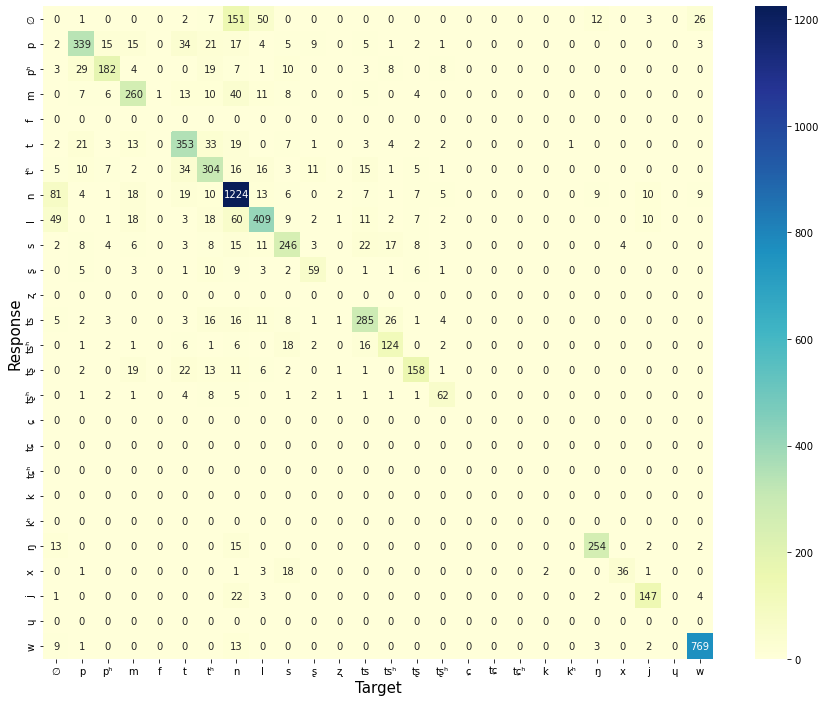

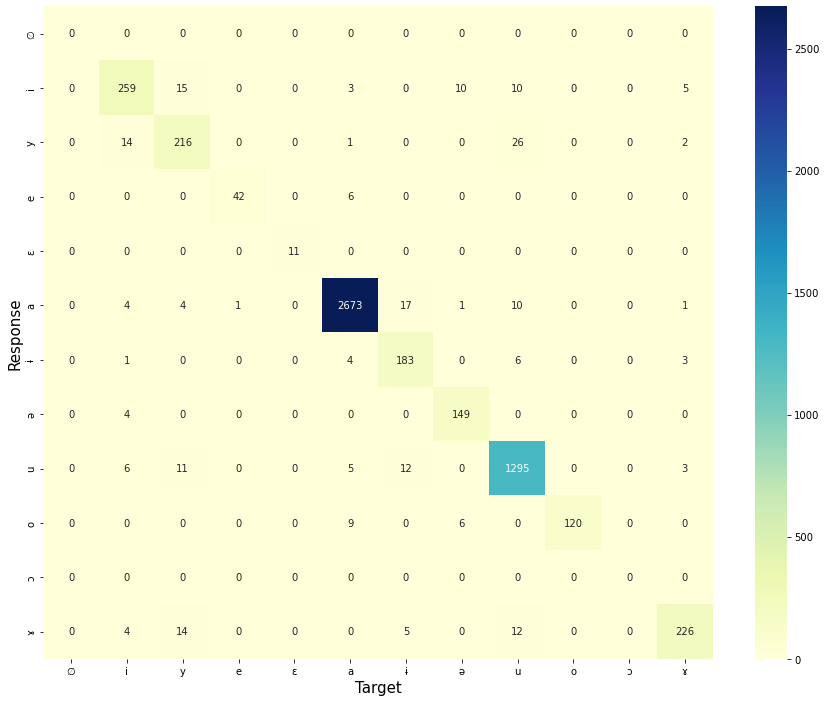

In [74]:
conconf = pd.DataFrame(0, columns=nconsonent, index=nconsonent)
vowconf = pd.DataFrame(0, columns=nvowel, index=nvowel)
adrcount = pd.Series(data=0, index=adlabel)

#print(adrcount)

def phoneme_calc(df):

    #print(conconf)
    #print(vowconf)

    tg = df['Target'].to_list()
    print("Target", tg)

    for t in title:
        #print(t)
        ans = df[t].to_list()
        idx = 1
        for it, ia in zip(tg, ans):
            #idx = idx + 1
            lit = it.split('-')
            lia = ia.split('-')
            #print(lit, lia)
            for ilit, ilia in zip(lit, lia):
                ts= ilit.split(' ')
                xs = ilia.split(' ')
                #print(ts, xs)
                lits = ts[:-1]
                lixs = xs[:-1]
                pits = ts[-1]
                pixs = xs[-1]
                if lixs[0] != 'x':
                    #print(lits, lixs, pits, pixs)
                    plits = phoneme_segmentation(lits[0])
                    #print(plits)
                    plixs = phoneme_segmentation(lixs[0])
                    clits = to_cgvn(zdf, plits)
                    clixs = to_cgvn(zdf, plixs)
                    sm = edit_distance.SequenceMatcher(a=plits, b=plixs)
                    op=sm.get_opcodes()
                    dist=sm.distance()
                    oplist = to_oplist(op)
                    #print(oplist)
                    #sm.ratio()
                    #sm.get_matching_blocks()
                    if dist == 0:
                        conf_matrix_inc(conconf, vowconf, plits, plixs)
                    elif dist == 1:
                        #print(plits, plixs, end=" ")
                        #print(clits, clixs, end=" ")
                        #print(dist, oplist, end=" ")

                        if 'insert' in oplist:
                            idx = oplist.index('insert')
                            plits.insert(idx, "∅")
                            #print(plits, plixs)
                            conf_matrix_inc(conconf, vowconf, plits, plixs)
                        elif 'delete' in oplist:
                            idx = oplist.index('delete')
                            plixs.insert(idx, "∅")
                            conf_matrix_inc(conconf, vowconf, plits, plixs)
                            #print(plits, plixs)
                        else:
                            # Replace, put info to confusion matrix
                            conf_matrix_inc(conconf, vowconf, plits, plixs)
                            #print(plits, plixs)
                            
                        misclassifer(oplist, plits, plixs, clits, clixs, adrcount)
                    else:
                        # Distance is more than 2, it is complicated...
                        #print(dist, op)
                        print(plits, plixs, end=" ")
                        print(clits, clixs, end=" ")
                        print(pits, pixs, end=" ")
                        print(dist, oplist)
                else:
                    pass
                    #print("No answer")
                                        
    return conconf, vowconf



c, v = phoneme_calc(df0)
#plot_conf(c,v)
#print("----")
c, v = phoneme_calc(df1)
plot_conf(c,v)

In [66]:
print(adrcount)

ISCD       68
ISG1D       7
F2G2D       3
ISCG1D      0
SVD         0
ISN1D       0
FSN2D      94
ISCA       60
ISG1A      16
FSG2A      11
ISCG1A      2
SVA         0
ISN1A       0
FSN2A     163
dtype: int64
